# Read in FMI Data and Train Some Models

# 1. Preparation

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# 2. Data

## 2.1 Dataset

In [2]:
# Import the weather measurements.
data = pd.read_csv('FMIData.csv')

print(data.head())

# We consider each temperature measurement (=a row in dataframe data) 
# as a separate data point.
# Determine the total number of data points stored in csv file.
nrdatapoints = len(data)

# Print out the first data point (first row).
print("First data point:")
print(data.iloc[0])
print("\n******************************\n")

# Here is another data point. 
print("Another data point:")
print(data.iloc[13])
print("\n******************************\n")

# We use normalized values of 
# latitude, longitude, year, mon, day, hour, minute (as float values) 
# as features of a data point.
nrfeatures = 7 

# The code snippet below extracts the features of the first data point (first row in dataframe data).
date_object = datetime.strptime(data['Timestamp'].iloc[0], '%Y-%m-%d %H:%M:%S')

# Extract individual components.
latitude = data["Latitude"].iloc[0]
longitude = data["Longitude"].iloc[0]
year = float(date_object.year)
month = float(date_object.month)
day = float(date_object.day)
hour = float(date_object.hour)
minute = float(date_object.minute)

print("Unnormalized features of the first data point: ")
print(f"Latitude: {latitude}")
print(f"Longitude: {longitude}")
print(f"Year: {year}")
print(f"Month: {month}")
print(f"Day: {day}")
print(f"Hour: {hour}")
print(f"Minute: {minute}")
print("\n******************************\n")

print("Normalized features of the first data point: ")
print(f"Latitude: {latitude/100}")
print(f"Longitude: {longitude/100}")
print(f"Year: {year/2025}")
print(f"Month: {month/13}")
print(f"Day: {day/32}")
print(f"Hour: {hour/25}")
print(f"Minute: {minute/61}")
print("\n******************************\n")

# We choose the temperature as the label (quantity of interest) of a data point.
print("Label of the first data point:", data["temp"].iloc[0])

   Latitude  Longitude            Timestamp  temp                         name
0  69.04277   20.85091  2023-12-31 18:00:00 -16.5  Enontekiö Kilpisjärvi Saana
1  64.11197   28.33639  2023-12-30 00:00:00 -12.4           Sotkamo Kuolaniemi
2  64.11197   28.33639  2023-12-30 15:00:00 -10.5           Sotkamo Kuolaniemi
3  70.08203   27.89650  2023-12-30 11:00:00 -25.3              Utsjoki Nuorgam
4  59.95911   19.95374  2023-12-31 03:00:00  -3.1               Lemland Nyhamn
First data point:
Latitude                        69.04277
Longitude                       20.85091
Timestamp            2023-12-31 18:00:00
temp                               -16.5
name         Enontekiö Kilpisjärvi Saana
Name: 0, dtype: object

******************************

Another data point:
Latitude                     69.757
Longitude                    27.012
Timestamp       2023-12-31 13:00:00
temp                          -26.3
name         Utsjoki Kevo Kevojärvi
Name: 13, dtype: object

**********************

## 2.2 Features and labels

In [3]:
# We next build the feature matrix X (each of its rows hold the features of a data point) 
# and the label vector y (whose entries hold the labels of data points).
X = np.zeros((nrdatapoints, nrfeatures))
y = np.zeros((nrdatapoints, 1))

# Iterate over all rows in dataframe and create corresponding feature vector and label. 
for ind in data.index:
    # Latitude of FMI station, normalized by 100. 
    lat = float(data['Latitude'].iloc[ind]) / 100
    
    # Longitude of FMI station, normalized by 100.
    lon = float(data['Longitude'].iloc[ind]) / 100
    
    # Exctract the temperature value.
    tmp = data['temp'].iloc[ind]
    
    # Read the date and time of the temperature measurement.
    date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')

    # Extract year, month, day, hour, minute, and second. 
    # Normalize these values to ensure features are in range [0,1].
    year = float(date_object.year) / 2025
    month = float(date_object.month) / 13
    day = float(date_object.day) / 32
    hour = float(date_object.hour) / 25
    minute = float(date_object.minute) / 61
    
    # Store the data point's features and a label.
    X[ind,:] = [lat, lon, year, month, day, hour, minute]
    y[ind,:] = tmp

print(f"The created feature matrix contains {np.shape(X)[0]} entries of {np.shape(X)[1]} features each.")
print(f"The created label vector contains {np.shape(y)[0]} measurements.")

The created feature matrix contains 19768 entries of 7 features each.
The created label vector contains 19768 measurements.


## 2.3 Training and validation sets

In [4]:
# Define the number of data points used for training set.
trainsize = 100

# Split the dataset into training and validation set. 
Xtrain = X[:trainsize,:] 
Xval = X[trainsize:] 
ytrain = y[:trainsize] 
yval = y[trainsize:] 

print(f"The training set consists of {np.shape(Xtrain)[0]} data points.")
print(f"The validation set consists of {np.shape(Xval)[0]} data points.")

The training set consists of 100 data points.
The validation set consists of 19668 data points.


# 3. Model

## 3.1 Linear regression

In [5]:
# We next train and validate a Linear Regression model. 
linmodel = LinearRegression()

# Train the linear model, i.e., solve the ERM to obtain parameters 
# of the linear model.
linmodel.fit(Xtrain, ytrain)
Etrain = mean_squared_error(ytrain, linmodel.predict(Xtrain))
Eval = mean_squared_error(yval, linmodel.predict(Xval))

print("\n*************** Linear Regression Diagnosis ***************")
print("Training error:", Etrain)
print("Validation error:", Eval)


*************** Linear Regression Diagnosis ***************
Training error: 17.082721372329612
Validation error: 18.254110378788724


## 3.2 Polynomial features

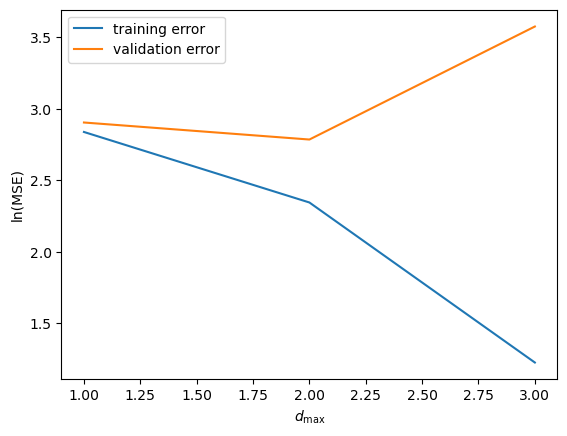

In [6]:
# Define the polynomial degrees.
maxdegreevals = [1, 2, 3]

# Initialize the arrays to store training and validation errors.
trainerr = np.zeros((len(maxdegreevals),1))
valerr = np.zeros((len(maxdegreevals),1))

for i, degree in enumerate(maxdegreevals): 
    poly = PolynomialFeatures(degree)
    Xnew = poly.fit_transform(X)
    Xtrain = Xnew[0:trainsize,:] 
    Xval = Xnew[trainsize:] 
    ytrain = y[0:trainsize] 
    yval = y[trainsize:] 
    linmodel.fit(Xtrain, ytrain)
    trainerr[i] = np.log(mean_squared_error(ytrain, linmodel.predict(Xtrain)))
    valerr[i] = np.log(mean_squared_error(yval, linmodel.predict(Xval)))
    
# Plot the training and validation errors.
plt.plot(maxdegreevals, np.hstack([trainerr, valerr]))
plt.legend(["training error","validation error"])
plt.xlabel(r'$d_{\rm max}$')
plt.ylabel('ln(MSE)')
plt.show()

## 3.3 Ridge regression

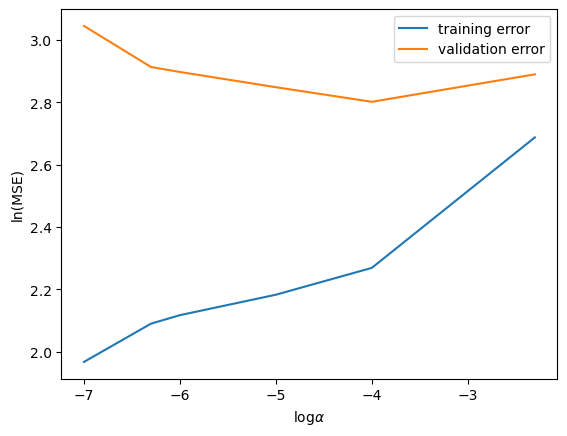

In [7]:
# Values for the GTVMin parameter alpha.
GTVmin_parameter = np.array([1e-9, 5e-9, 1e-8, 1e-7,1e-6,5e-5]) 
# The input paramter 'alpha' for RidgeRegression class requires a scaling by the samplesize.
alphavals = GTVmin_parameter * trainsize
# The maximal degree of polynomial combinations of original features used to create more features.
poly_degree = 3

poly = PolynomialFeatures(poly_degree)
X_poly = poly.fit_transform(X)

Xtrain_poly = X_poly[:trainsize,:] 
Xval_poly = X_poly[trainsize:] 
ytrain = y[:trainsize] 
yval = y[trainsize:] 

trainerr = np.zeros((len(alphavals), 1))
valerr = np.zeros((len(alphavals), 1))

for i, alpha in enumerate(alphavals): 
    ridgeest = Ridge(alpha=alpha)
    ridgeest.fit(Xtrain_poly,ytrain)
    trainerr[i] = np.log(mean_squared_error(ytrain, ridgeest.predict(Xtrain_poly)))
    valerr[i] = np.log(mean_squared_error(yval, ridgeest.predict(Xval_poly)))
    
# Plot the training and validation errors.
plt.plot(np.log10(alphavals), trainerr)
plt.plot(np.log10(alphavals), valerr)
plt.legend(['training error', 'validation error'])
plt.xlabel(r'${\rm log} \alpha$')
plt.ylabel('ln(MSE)')
plt.show()

# 4. Design Choice Model

In [8]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Define the number of data points used for training set.
trainsize = 100

# Split the dataset into training and validation set. 
Xtrain = X[:trainsize,:] 
Xval = X[trainsize:] 
ytrain = y[:trainsize] 
yval = y[trainsize:]

# Define the models to train
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR()
}

# Train each model and evaluate it
results = {}
for name, model in models.items():
    # Train the model
    model.fit(Xtrain, ytrain)
    
    # Predict on training and validation set
    y_train_pred = model.predict(Xtrain)
    y_val_pred = model.predict(Xval)
    
    # Calculate the errors
    train_error = mean_squared_error(ytrain, y_train_pred)
    val_error = mean_squared_error(yval, y_val_pred)
    
    # Store the results
    results[name] = {
        'Training Error': train_error,
        'Validation Error': val_error
    }

# Display the results
for model_name, errors in results.items():
    print(f"{model_name} - Training Error: {errors['Training Error']:.2f}, Validation Error: {errors['Validation Error']:.2f}")

/Users/junga1/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/junga1/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Linear Regression - Training Error: 17.08, Validation Error: 18.25
Decision Tree - Training Error: 0.00, Validation Error: 20.06
Random Forest - Training Error: 1.78, Validation Error: 14.67
Support Vector Machine - Training Error: 37.85, Validation Error: 46.73


# 5. Design Choice Dataset

## Data point = some time period

In [19]:
import pandas as pd

# Load the CSV file
data_path = 'FMIData.csv'  # Replace with the actual path to your file
data = pd.read_csv(data_path)

# Convert the 'DateTime' column to datetime type
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Pivot the table to get weather stations as columns and hourly time periods as rows
pivot_table = data.pivot_table(values='temp', index='Timestamp', columns='name', aggfunc='mean')

print(pivot_table)
# Display the pivoted DataFrame
#for col in pivot_table.columns: 
 #   print(pivot_table[col])

name                 Alajärvi Möksy  Asikkala Pulkkilanharju  \
Timestamp                                                      
2023-12-28 11:00:00            -5.4                     -3.7   
2023-12-28 12:00:00            -5.2                     -3.6   
2023-12-28 13:00:00            -5.1                     -5.1   
2023-12-28 14:00:00            -5.1                     -5.0   
2023-12-28 15:00:00            -5.0                     -4.5   
...                             ...                      ...   
2024-01-01 06:00:00           -25.3                    -22.0   
2024-01-01 07:00:00           -26.5                    -21.9   
2024-01-01 08:00:00           -27.0                    -23.4   
2024-01-01 09:00:00           -23.9                    -22.3   
2024-01-01 10:00:00           -21.8                    -19.5   

name                 Enontekiö Kilpisjärvi Saana  \
Timestamp                                          
2023-12-28 11:00:00                         -7.9   
2023-12-28 

## Data point = some weather station

In [10]:
# Load the CSV file
data_path = 'FMIData.csv'  # Replace with the actual path to your file
data = pd.read_csv(data_path)

# Convert the 'DateTime' column to datetime type
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Pivot the table to get weather stations as columns and hourly time periods as rows
pivot_table = data.pivot_table(values=['temp','Latitude'], index='name', columns='Timestamp', aggfunc='mean')

print(pivot_table)

                                            Latitude                      \
Timestamp                        2023-12-28 11:00:00 2023-12-28 12:00:00   
name                                                                       
Alajärvi Möksy                              63.08898            63.08898   
Asikkala Pulkkilanharju                     61.26521            61.26521   
Enontekiö Kilpisjärvi Saana                 69.04277            69.04277   
Enontekiö Kilpisjärvi kyläkeskus            69.03905            69.03905   
Enontekiö Näkkälä                           68.60301            68.60301   
...                                              ...                 ...   
Virolahti Koivuniemi                        60.52720            60.52720   
Virrat Äijänneva                            62.32783            62.32783   
Ylitornio Meltosjärvi                       66.52952            66.52952   
Ylivieska lentokenttä                       64.05029            64.05029   
Ähtäri Inha 